<a href="https://colab.research.google.com/github/evacheung0929/Reinforcement-learning-agents/blob/main/DP_MC_TD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import random
import matplotlib.pyplot as plt # Graphical library
#from sklearn.metrics import mean_squared_error # Mean-squared error function

In [ ]:

def get_CID():

  return "02168333" # Return your CID (add 0 at the beginning to ensure it is 8 digits long)

def get_login():
  return "ec1121" # Return your short imperial login

## Helper class

In [ ]:
# This class is used ONLY for graphics
# YOU DO NOT NEED to understand it to work on this coursework

class GraphicsMaze(object):

  def __init__(self, shape, locations, default_reward, obstacle_locs, absorbing_locs, absorbing_rewards, absorbing):

    self.shape = shape
    self.locations = locations
    self.absorbing = absorbing

    # Walls
    self.walls = np.zeros(self.shape)
    for ob in obstacle_locs:
      self.walls[ob] = 20

    # Rewards
    self.rewarders = np.ones(self.shape) * default_reward
    for i, rew in enumerate(absorbing_locs):
      self.rewarders[rew] = 10 if absorbing_rewards[i] > 0 else -10

    # Print the map to show it
    self.paint_maps()

  def paint_maps(self):
    """
    Print the Maze topology (obstacles, absorbing states and rewards)
    input: /
    output: /
    """
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders)
    plt.show()

  def paint_state(self, state):
    """
    Print one state on the Maze topology (obstacles, absorbing states and rewards)
    input: /
    output: /
    """
    states = np.zeros(self.shape)
    states[state] = 30
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders + states)
    plt.show()

  def draw_deterministic_policy(self, Policy):
    """
    Draw a deterministic policy
    input: Policy {np.array} -- policy to draw (should be an array of values between 0 and 3 (actions))
    output: /
    """
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders) # Create the graph of the Maze
    for state, action in enumerate(Policy):
      if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any action
        continue
      arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"] # List of arrows corresponding to each possible action
      action_arrow = arrows[action] # Take the corresponding action
      location = self.locations[state] # Compute its location on graph
      plt.text(location[1], location[0], action_arrow, ha='center', va='center') # Place it on graph
    plt.show()

  def draw_policy(self, Policy):
    """
    Draw a policy (draw an arrow in the most probable direction)
    input: Policy {np.array} -- policy to draw as probability
    output: /
    """
    deterministic_policy = np.array([np.argmax(Policy[row,:]) for row in range(Policy.shape[0])])
    self.draw_deterministic_policy(deterministic_policy)

  def draw_value(self, Value):
    """
    Draw a policy value
    input: Value {np.array} -- policy values to draw
    output: /
    """
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders) # Create the graph of the Maze
    for state, value in enumerate(Value):
      if(self.absorbing[0, state]): # If it is an absorbing state, don't plot any value
        continue
      location = self.locations[state] # Compute the value location on graph
      plt.text(location[1], location[0], round(value,2), ha='center', va='center') # Place it on graph
    plt.show()

  def draw_deterministic_policy_grid(self, Policies, title, n_columns, n_lines):
    """
    Draw a grid representing multiple deterministic policies
    input: Policies {np.array of np.array} -- array of policies to draw (each should be an array of values between 0 and 3 (actions))
    output: /
    """
    plt.figure(figsize=(20,8))
    for subplot in range (len(Policies)): # Go through all policies
      ax = plt.subplot(n_columns, n_lines, subplot+1) # Create a subplot for each policy
      ax.imshow(self.walls+self.rewarders +self.absorbers) # Create the graph of the Maze
      for state, action in enumerate(Policies[subplot]):
        if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any action
          continue
        arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"] # List of arrows corresponding to each possible action
        action_arrow = arrows[action] # Take the corresponding action
        location = self.locations[state] # Compute its location on graph
        plt.text(location[1], location[0], action_arrow, ha='center', va='center') # Place it on graph
      ax.title.set_text(title[subplot]) # Set the title for the graph given as argument
    plt.show()

  def draw_policy_grid(self, Policies, title, n_columns, n_lines):
    """
    Draw a grid representing multiple policies (draw an arrow in the most probable direction)
    input: Policy {np.array} -- array of policies to draw as probability
    output: /
    """
    deterministic_policies = np.array([[np.argmax(Policy[row,:]) for row in range(Policy.shape[0])] for Policy in Policies])
    self.draw_deterministic_policy_grid(deterministic_policies, title, n_columns, n_lines)

  def draw_value_grid(self, Values, title, n_columns, n_lines):
    """
    Draw a grid representing multiple policy values
    input: Values {np.array of np.array} -- array of policy values to draw
    output: /
    """
    plt.figure(figsize=(20,8))
    for subplot in range (len(Values)): # Go through all values
      ax = plt.subplot(n_columns, n_lines, subplot+1) # Create a subplot for each value
      ax.imshow(self.walls+self.rewarders +self.absorbers) # Create the graph of the Maze
      for state, value in enumerate(Values[subplot]):
        if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any value
          continue
        location = self.locations[state] # Compute the value location on graph
        plt.text(location[1], location[0], round(value,1), ha='center', va='center') # Place it on graph
      ax.title.set_text(title[subplot]) # Set the title for the graoh given as argument
    plt.show()


## Maze class

In [ ]:
# This class define the Maze environment

class Maze(object):

  # [Action required]
  def __init__(self):
    """
    Maze initialisation.
    input: /
    output: /
    """
    
    # [Action required]
    # Properties set from the CID
    #self._prob_success = 0.25
    self._prob_success = 0.92 # float
    self._gamma = 0.86 # float
    self._goal = 3 # integer (0 for R0, 1 for R1, 2 for R2, 3 for R3)

    # Build the maze
    self._build_maze()
                              

  # Functions used to build the Maze environment 
  # You DO NOT NEED to modify them
  def _build_maze(self):
    """
    Maze initialisation.
    input: /
    output: /
    """

    # Properties of the maze
    self._shape = (13, 10)
    self._obstacle_locs = [
                          (1,0), (1,1), (1,2), (1,3), (1,4), (1,7), (1,8), (1,9), \
                          (2,1), (2,2), (2,3), (2,7), \
                          (3,1), (3,2), (3,3), (3,7), \
                          (4,1), (4,7), \
                          (5,1), (5,7), \
                          (6,5), (6,6), (6,7), \
                          (8,0), \
                          (9,0), (9,1), (9,2), (9,6), (9,7), (9,8), (9,9), \
                          (10,0)
                         ] # Location of obstacles
    self._absorbing_locs = [(2,0), (2,9), (10,1), (12,9)] # Location of absorbing states
    self._absorbing_rewards = [ (500 if (i == self._goal) else -50) for i in range (4) ]
    self._starting_locs = [(0,0), (0,1), (0,2), (0,3), (0,4), (0,5), (0,6), (0,7), (0,8), (0,9)] #Reward of absorbing states
    self._default_reward = -1 # Reward for each action performs in the environment
    self._max_t = 500 # Max number of steps in the environment

    # Actions
    self._action_size = 4
    self._direction_names = ['N','E','S','W'] # Direction 0 is 'N', 1 is 'E' and so on
        
    # States
    self._locations = []
    for i in range (self._shape[0]):
      for j in range (self._shape[1]):
        loc = (i,j) 
        # Adding the state to locations if it is no obstacle
        if self._is_location(loc):
          self._locations.append(loc)
    self._state_size = len(self._locations)

    # Neighbours - each line is a state, ranked by state-number, each column is a direction (N, E, S, W)
    self._neighbours = np.zeros((self._state_size, 4)) 
    
    for state in range(self._state_size):
      loc = self._get_loc_from_state(state)

      # North
      neighbour = (loc[0]-1, loc[1]) # North neighbours location
      if self._is_location(neighbour):
        self._neighbours[state][self._direction_names.index('N')] = self._get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        self._neighbours[state][self._direction_names.index('N')] = state

      # East
      neighbour = (loc[0], loc[1]+1) # East neighbours location
      if self._is_location(neighbour):
        self._neighbours[state][self._direction_names.index('E')] = self._get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        self._neighbours[state][self._direction_names.index('E')] = state

      # South
      neighbour = (loc[0]+1, loc[1]) # South neighbours location
      if self._is_location(neighbour):
        self._neighbours[state][self._direction_names.index('S')] = self._get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        self._neighbours[state][self._direction_names.index('S')] = state

      # West
      neighbour = (loc[0], loc[1]-1) # West neighbours location
      if self._is_location(neighbour):
        self._neighbours[state][self._direction_names.index('W')] = self._get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        self._neighbours[state][self._direction_names.index('W')] = state

    # Absorbing
    self._absorbing = np.zeros((1, self._state_size))
    for a in self._absorbing_locs:
      absorbing_state = self._get_state_from_loc(a)
      self._absorbing[0, absorbing_state] = 1

    # Transition matrix
    self._T = np.zeros((self._state_size, self._state_size, self._action_size)) # Empty matrix of domension S*S*A
    for action in range(self._action_size):
      for outcome in range(4): # For each direction (N, E, S, W)
        # The agent has prob_success probability to go in the correct direction
        if action == outcome:
          prob = 1 - 3.0 * ((1.0 - self._prob_success) / 3.0) # (theoritically equal to self.prob_success but avoid rounding error and garanty a sum of 1)
        # Equal probability to go into one of the other directions
        else:
          prob = (1.0 - self._prob_success) / 3.0
          
        # Write this probability in the transition matrix
        for prior_state in range(self._state_size):
          # If absorbing state, probability of 0 to go to any other states
          if not self._absorbing[0, prior_state]:
            post_state = self._neighbours[prior_state, outcome] # Post state number
            post_state = int(post_state) # Transform in integer to avoid error
            self._T[prior_state, post_state, action] += prob

    # Reward matrix
    self._R = np.ones((self._state_size, self._state_size, self._action_size)) # Matrix filled with 1
    self._R = self._default_reward * self._R # Set default_reward everywhere
    for i in range(len(self._absorbing_rewards)): # Set absorbing states rewards
      post_state = self._get_state_from_loc(self._absorbing_locs[i])
      self._R[:,post_state,:] = self._absorbing_rewards[i]

    # Creating the graphical Maze world
    self._graphics = GraphicsMaze(self._shape, self._locations, self._default_reward, self._obstacle_locs, self._absorbing_locs, self._absorbing_rewards, self._absorbing)
    
    # Reset the environment
    self.reset()


  def _is_location(self, loc):
    """
    Is the location a valid state (not out of Maze and not an obstacle)
    input: loc {tuple} -- location of the state
    output: _ {bool} -- is the location a valid state
    """
    if (loc[0] < 0 or loc[1] < 0 or loc[0] > self._shape[0]-1 or loc[1] > self._shape[1]-1):
      return False
    elif (loc in self._obstacle_locs):
      return False
    else:
      return True


  def _get_state_from_loc(self, loc):
    """
    Get the state number corresponding to a given location
    input: loc {tuple} -- location of the state
    output: index {int} -- corresponding state number
    """
    return self._locations.index(tuple(loc))


  def _get_loc_from_state(self, state):
    """
    Get the state number corresponding to a given location
    input: index {int} -- state number
    output: loc {tuple} -- corresponding location
    """
    return self._locations[state]

  # Getter functions used only for DP agents
  # You DO NOT NEED to modify them
  def get_T(self):
    return self._T ############################################# T[0,0]

  def get_R(self):
    return self._R

  def get_absorbing(self):
    return self._absorbing

  # Getter functions used for DP, MC and TD agents
  # You DO NOT NEED to modify them
  def get_graphics(self):
    return self._graphics

  def get_action_size(self):
    return self._action_size

  def get_state_size(self):
    return self._state_size

  def get_gamma(self):
    return self._gamma

  # Functions used to perform episodes in the Maze environment
  def reset(self):
    """
    Reset the environment state to one of the possible starting states
    input: /
    output: 
      - t {int} -- current timestep
      - state {int} -- current state of the envionment
      - reward {int} -- current reward
      - done {bool} -- True if reach a terminal state / 0 otherwise
    """
    self._t = 0
    self._state = self._get_state_from_loc(self._starting_locs[random.randrange(len(self._starting_locs))])
    self._reward = 0
    self._done = False
    return self._t, self._state, self._reward, self._done

  def step(self, action):
    """
    Perform an action in the environment
    input: action {int} -- action to perform
    output: 
      - t {int} -- current timestep
      - state {int} -- current state of the envionment
      - reward {int} -- current reward
      - done {bool} -- True if reach a terminal state / 0 otherwise
    """

    # If environment already finished, print an error
    if self._done or self._absorbing[0, self._state]:
      print("Please reset the environment")
      return self._t, self._state, self._reward, self._done

    # Drawing a random number used for probaility of next state
    probability_success = random.uniform(0,1)

    # Look for the first possible next states (so get a reachable state even if probability_success = 0)
    new_state = 0
    while self._T[self._state, new_state, action] == 0: 
      new_state += 1
    assert self._T[self._state, new_state, action] != 0, "Selected initial state should be probability 0, something might be wrong in the environment."

    # Find the first state for which probability of occurence matches the random value
    total_probability = self._T[self._state, new_state, action]
    while (total_probability < probability_success) and (new_state < self._state_size-1):
     new_state += 1
     total_probability += self._T[self._state, new_state, action]
    assert self._T[self._state, new_state, action] != 0, "Selected state should be probability 0, something might be wrong in the environment."
    
    # Setting new t, state, reward and done
    self._t += 1
    self._reward = self._R[self._state, new_state, action]
    self._done = self._absorbing[0, new_state] or self._t > self._max_t
    self._state = new_state
    return self._t, self._state, self._reward, self._done



```
# This is formatted as code
```

## DP Agent

In [ ]:
# This class define the Dynamic Programing agent 
#We can obtain the optimal policies once we have found the optimal value function
class DP_agent(object):
  def solve(self,env):
    transitionM = env.get_T()
    reward = env.get_R()
    absorb = env.get_absorbing()
    actionSize = env.get_action_size()
    stateSize = env.get_state_size()
    gamma = env.get_gamma()
    policy = np.zeros((stateSize, actionSize))

    # Initialisation for policy, state based on state sizes
    values = np.zeros(stateSize)  # intialise value function
    ######
    threshold = 0.001  # val too small = won't be able to converge, computational power
    vDifference = 2 * threshold
    ep = 0
    #pStable = False
    sumQ = np.zeros(actionSize)
    ########
    
    # Ensure gamma value is valid 
    assert (gamma <=1) and (gamma >= 0)
    # Loop to check if the policy reached a stable state, hence convergence
    while threshold <=vDifference:
        ep += 1
        vDifference = 0

        for s in range(stateSize):                                                            # starting states
          if not absorb[0, s]:                                                                # making sure the current state is NOT absorbed, so 0, otherwise would be 1
            sumV = values[s] 
            sumQ = np.zeros(actionSize)                                                                          # this temporary variable holds the sum of the value function during the count
            for sDash in range(stateSize):                                                                   
                sumQ += transitionM[s, sDash, :] * (reward[s, sDash, :] + gamma * values[sDash])  # Bellman update
            values[s] =np.max(sumQ)
            vDifference = max(vDifference, np.abs(sumV - values[s]))  ################
    
    for s in range(stateSize):
      sumQ = np.zeros(actionSize)     
      for sDash in range(stateSize):       
        sumQ += transitionM [s , sDash, : ] *  ( reward[s, sDash, :] + (gamma * values[sDash]))
      
      policy [s,np.argmax(sumQ)] = 1  #index for a specific action that returns tthe max  value, EVERYTHING else is 0, when the correc indexprob = 1
  
    return policy, values





## MC agent

In [ ]:
# This class define the Monte-Carlo agent

class MC_agent(object):

  # def rewardPlot(reward):
  #   plt.figure(fSize = (20,20)
  #   print(reward.shape)
  #   print(type(rewards))
  #   total = totalRewards(axis=0)


  # def greedPolicy(epsilon):
  #   #HOW to get the trace, we need to use the greedy policy to choose the action when in certain state
  #   # Assign a random probability to the 
  #   prob = np.random.rand()
  #   if prob < epsilion :#or 1-eplison?:
  #     policy = (1 - epsilion + epsilion/env.action_size) #argmax policy
  #     action = np.random.choice(env.action_size, policy)
  #   policy = 1 - (1- epsilion/env.action_size)    #explore
  #   action = np.argmax(env.action_size)
  #   return action, policy

  # [Action required]
  # WARNING: make sure this function can be called by the auto-marking script
  #Exploring & exploiting 
  def solve(self, env):
    """
    Solve a given Maze environment using Monte Carlo learning
    input: env {Maze object} -- Maze to solve
    output: 
      - policy {np.array} -- Optimal policy found to solve the given Maze environment 
      - values {list of np.array} -- List of successive value functions for each episode 
      - total_rewards {list of float} -- Corresponding list of successive total non-discounted sum of reward for each episode 
    """

    actionSize = env.get_action_size()
    stateSize = env.get_state_size()
    Q = np.random.rand(stateSize, actionSize) 
    V = np.zeros(stateSize)
    G = np.zeros((stateSize,actionSize))
    values = [V]
    total_rewards=[]
    episodes = 3000
    gamma = env.get_gamma()
    policy = np.ones((stateSize, actionSize)) *0.25
    epsilion = 0.99                          #add noise? #at first gon take random action (if set it to be low, it only go to one )
    G = np.zeros((stateSize,actionSize))
    currentPair = np.zeros((stateSize,actionSize)) 

    ##############################
    #alpha = 0.5
    ##############################
    #looping through each episode, print the current working episode for tracking
    for i in range(episodes):                 #lot of trace makes up a sample
      totalRewards = 0
      if i %1000 == 0:
        print(i)
      #reset  
      
      t,firstState, reward, done = env.reset()
      trace=[]
      #totalSteps = 0
      visitPair = set() 
      while not done:   
        prob = np.random.random()           
        if prob < epsilion:
          action = np.random.choice(range(actionSize))       #,policy[firstState,:]      #can't use actionSize, which is an integer?
        else:
          action = np.argmax(policy[firstState,:])  
        t,state, reward, done = env.step(action)
        trace.append([firstState,action,reward])           #first state is the state we took the action, returning the reward 
        firstState = state                                     #the "next state" will now become the firstState
        #totalSteps+=1
        
#if I have been to that state, then skip ()
#if I have nott been to that state, append the stateVisit to the set

      # R = current reward, 
      # reward = all the previous accumulated reward
      R = 0

      # get the most recent s,a,r
      for n in reversed(range(t)):        #(0,totalSteps,1): #range is inclusive 
        state = trace[n][0]
        action = trace[n][1]
        reward = trace[n][2]
        totalRewards += reward                                  #giving us a list of reward

        # the G[state, action] here is useless
        # updating the current reward based on the previous rewards using the equation
        R = gamma* R + reward
        G[state, action] += R 
        pair = (state,action)                                   #action is a list with one element, so we set the [0] to be tuple                                          

        # first-visit, only add pair if the pair has not been seen before
        if pair in visitPair:                                  #skip the update & policy the current state-action pair
          continue
        visitPair.add(pair)                                   #Add the first appearance of the (s,a) to the set
        currentPair[state,action] += 1                        #the count for the num of pair in the set increment               
        alpha = 1/currentPair[state,action]
        Q[state,action] = Q[state, action] + alpha * (R - Q[state, action])         #smaller the alpha = keeping less memory of the previous value as the stateVisit value increase #larger alpha = the value funcion  
       # print('Q value ' + str(Q[state,action]) + ' for state ' + str(state) + ' and action ')
        max_index = np.argmax(Q[state,:]) #return the index of the maxium action, which will be used later to provide the policy
        policy[state,:] =  epsilion/actionSize   #epsilion/actionSize #assign   
        policy[state,max_index] = 1 - epsilion + epsilion/actionSize    #converge, no need 1 - epsilion + epsilion/actionSize coz       
        
        #upddate V every episode
        V[state] = max(Q[state,:])

      epsilion *= 0.99         #epsilion gets smaller and smaller, allowing us the converge

      #set a temp value that can hold every single one of the value within the entire state size
      #
      # lol = []
      # for vSearch in range(stateSize):
      #   lol.append(vSearch)
      print(values)
      values.append(np.copy(V))
     # print(np.arrray(values).shape)
      total_rewards.append(totalRewards)
    return policy, values, total_rewards

# alpha



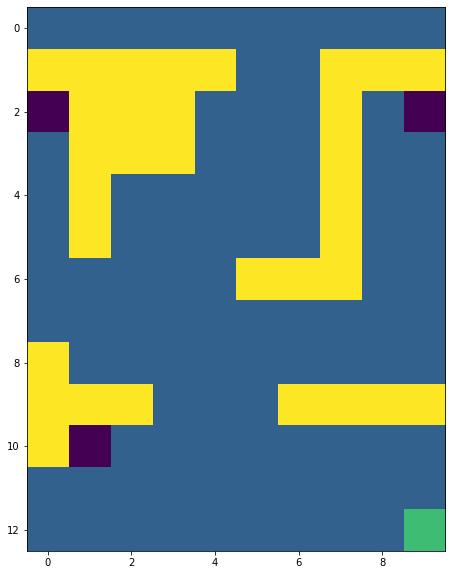

Streaming output truncated to the last 5000 lines.
        0.        ,  0.62371134,  0.58423394,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ]), array([-7.14285714e+00, -7.14285714e+00, -7.14285714e+00, -7.14285714e+00,
       -7.14285714e+00, -7.14285714e+00, -7.14285727e+00, -7.14285708e+00,
       -7.14285699e+00, -7.14285711e+00, -7.14264740e+00, -7.14065294e+00,
        0.00000000e+00, -7.12350480e+00, -7.13054743e+00, -7.12464807e+00,
        0.00000000e+00,  0.00000000e+00,  6.03096713e-01, -7.07907288e+00,
       -6.22383061e+00, -7.13241727e+00,  0.00000000e+00,  9.39095689e-01,
       -7.68296227e+00, -7.14285714e+00, -5.82214650e+00, -5.90025778e+00,
       -6.07422169e+00, -6.46314515e+00,  6.23742101e-01,  2.87381546e-01,
       -7.19908546e+00, -7.14285723e+00, -5.60714579e+00, -5.84046144e+00,
       -6.93947513e+00, -5.97375252e+00,  7.09466753e-01,  1.47004978e-01,
       -7.21234907e+00,  9.23306805e-01, -7.14291170e+00, -7.14285652e+00,
    

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
        -1.45912934,  -7.12199619,  -7.09574471,  -7.13824893,
        -7.13822923,  -5.4132404 ,  -5.45324673,  -5.63052776,
         0.87454788,   9.33960809,   6.41997032,  -7.09413106,
        -7.57589143,  -8.0867534 ,   1.81972139,  12.42846994,
        46.94960257,   0.        ,   9.17367977,   6.24857554,
         6.12742363,  65.32899191, 134.00208663, 142.58872036,
       186.75706394, 388.29333333, -16.13770991,  -9.11278269,
        -1.13123616,  18.28759692,  37.5590832 ,  60.28382852,
       197.79793962, 270.97593524, 362.96136346, 500.        ,
         0.75985438,  -8.60058002,  -9.4947338 ,  23.98016733,
        67.23497898,  81.32558648, 168.825881  , 320.32454844,
       500.        ,   0.        ]), array([-6.55743645e+00, -6.98005226e+00, -6.99312338e+00, -6.87576310e+00,
       -6.92657181e+00, -6.91019770e+00, -6.74983377e+00, -6.96362236e+00,
       -7.01082070e+00, -7.00149905e+00, -6.94564115e+00, -7.00895095

KeyboardInterrupt: ignored

In [ ]:
maze = Maze()
mc = MC_agent()
mc.solve(maze)
# print(m)

## TD agent

In [ ]:
# This class define the Temporal-Difference agent
#The update of Q depends on:
#s1,a1,r1
#s2 & a2

class TD_agent(object):

  # [Action required]
  # WARNING: make sure this function can be called by the auto-marking script
  def solve(self, env):
    """
    Solve a given Maze environment using Temporal Difference learning
    input: env {Maze object} -- Maze to solve
    output: 
      - policy {np.array} -- Optimal policy found to solve the given Maze environment 
      - values {list of np.array} -- List of successive value functions for each episode 
      - total_rewards {list of float} -- Corresponding list of successive total non-discounted sum of reward for each episode 
    """

    # Initialisation (can be edited)
    stateSize = env.get_state_size()
    actionSize = env.get_action_size()
    gamma = env.get_gamma()
    Q = np.random.rand(stateSize, actionSize) 
    V = np.zeros(stateSize)
    policy = np.zeros((stateSize, actionSize)) 
    values = [V]
    td_total_rewards = []
    stateVisits = 0
    epsilion = 0.99
    target = 0
    episodes= 3000
    alpha = 0.01 #

    
    for i in range(episodes):
      
      if i % 100 ==0:
        print(i)
      #initailse S, first state
      t,firstState, reward, done = env.reset()
      #choose first action usingg firstState based on epsilon greedy 
      prob = random.random()
      if prob < epsilion: 
        action =  np.random.choice(actionSize)
      else:
        action = np.argmax(policy[firstState,:])
      
      totalR = 0
      while not done:
        t,state, reward2, done = env.step(action) 
        
        #take nextAction , the state is our s' 
        prob = random.random()
        if prob < epsilion: 
          nextAction =  np.random.choice(actionSize)
        else:
          nextAction =  np.argmax(policy[state,:])
        #observe R based on action A, from the firstState, so r = reward
        totalR += reward2
        #observe S'("state")based on action ("action")
        #R + gammaQ(S',A')
        #Reward based on "action"
        target =  reward2 + gamma * Q[state,nextAction]
        #Q(S,A)
        Q[firstState,action] = Q[firstState,action] + alpha *(target - Q[firstState,action])
        
        firstState = state
        action = nextAction
        V[state] = max(Q[state,:])

        #update policy
        # for state in range(stateSize):
      # max_index = np.argmax(Q[state,:])
        max_index = np.argmax(Q[state,:]) #return the index of the maxium action, which will be used later to provide the policy
        policy[state,:] =  epsilion/actionSize   #epsilion/actionSize #assign   
        policy[state,max_index] = 1- epsilion + epsilion/actionSize    #converge, no need 1 - epsilion + epsilion/actionSize coz         max_index = np.argmax(Q[state,:]) #return the index of the maxium action, which will be used later to provide the policy
      
      # epsilion *= 0.99
      # alpha = 1/t**2
    
      td_total_rewards.append(totalR)
      values.append(np.copy(V))
     
    return policy, values, td_total_rewards

## Example main

Creating the Maze:



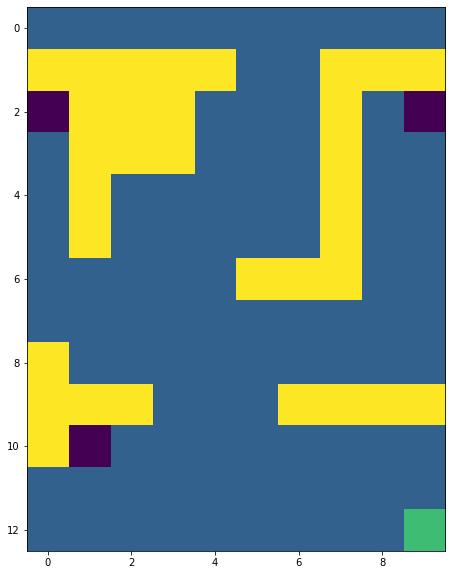

0
1000
2000


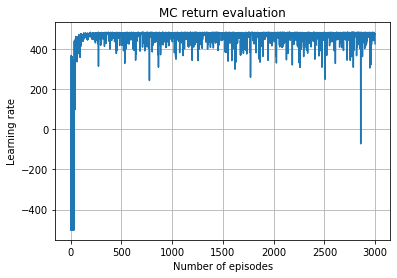

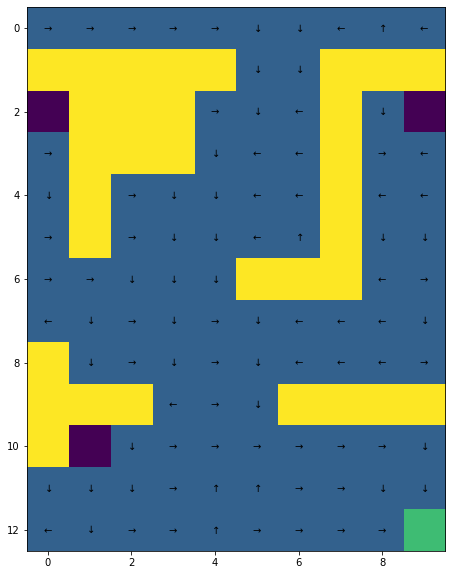

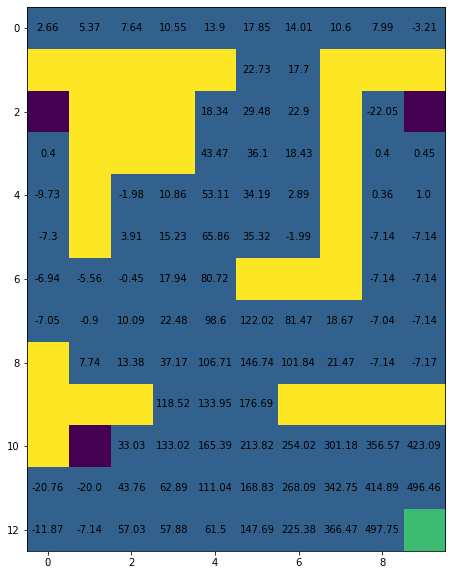

In [ ]:
# Example main (can be edited)
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

### Question 0: Defining the environment
print("Creating the Maze:\n")
maze = Maze()
# ### Question 1: Dynamic programming
# dp_agent = DP_agent()
# dp_policy, dp_value = dp_agent.solve(maze)
# print("Results of the DP agent:\n")
# maze.get_graphics().draw_policy(dp_policy)
# maze.get_graphics().draw_value(dp_value)
# ### Question 2: Monte-Carlo learning
##############################################################################################################################

# def plotReward(replication = 10, episodes = 3000):
#   mc_agent = MC_agent()
#   # contain 10x "reward" and "values" from each episode
#   mc_mean=[]                            
#   mc_sd=[]
#   m =[]
#   sd=[] 
#   #e = np.arange(episodes+1)                 
#   #compare same episode with every replication
#   #calculate the toal reward for each episode, which is later appended to the "mean" variable
#   #10 total reward
#   for i in range(replication):
#     _,mc_values,mc_total_rewards= mc_agent.solve(maze)   
#     #print("MC TTOTAL RE",np.array(mc_total_rewards).shape)
#     mc_mean.append(mc_total_rewards)    #shape is 1001,98
#     mc_sd.append(mc_total_rewards)
#   m = np.array(mc_mean).mean(axis=0)                     #cast the normal list into np.array
#   sd = np.array(mc_sd).std(axis=0)                       #cast the normal list into np.array
  
#   #plot mean reward
#   plt.plot(range(episodes),m, label = 'Mean MC Return Over 10 Replication', color = "black", alpha =0.2) #x axis
#   plt.fill_between(range(episodes),m+sd, label = ' + standard deviation of return over 10 replication', color = "green", alpha =0.2) #x axis
#   plt.fill_between(range(episodes),m-sd, label = ' - standard deviation return over 10 replication', color = "red", alpha =0.2) #x axis
#   plt.legend()
#   #plt.fill_between(range(episodes), m+sd, m-sd, color = "blue",alpha=0.2)
#   plt.ylabel('Learning rate')
#   plt.xlabel('Number of episodes')
#   plt.title('MC return evaluation overr 10 replication')
#   plt.grid()
#   plt.show()
#   return m, sd
# plotReward(replication = 100, episodes = 3000)

#############################################################################################################################
mc_agent = MC_agent()
mc_policy, mc_values, mc_total_rewards = mc_agent.solve(maze)
plt.plot(mc_total_rewards)
plt.ylabel('Learning rate')
plt.xlabel('Number of episodes')
plt.title('MC return evaluation')
plt.grid()
plt.show()


# print("Results of the MC agent:\n")
maze.get_graphics().draw_policy(mc_policy)
maze.get_graphics().draw_value(mc_values[-1])


# ### Question 3: Temporal-Difference learning############################################################################################################################## NEED TO CHANGE

# td_agent = TD_agent()
# td_policy, td_values, td_total_rewards = td_agent.solve(maze)

# print("Results of the TD agent:\n")
# maze.get_graphics().draw_policy(td_policy)
# maze.get_graphics().draw_value(td_values[-1])

# plt.plot(td_total_rewards)
# plt.ylabel('Learning rate')
# plt.xlabel('Number of episodes')
# plt.title('TD Return Evaluation (epsilion = 0.99, episodes = 3000, alpha = 1)')
# plt.grid()
# plt.show()
##############################################################################################################################

#mean squared eror 
# def mse(replication = 10, episodes = 3000):
#   dp_agent = DP_agent()
#   _,dp_value = dp_agent.solve(maze)
#   mc_agent = MC_agent()
#   td_agent = TD_agent()

#   mc_hold = []
#   td_hold = []
#   mc_mse = []
#   td_mse = []
#   mc_sd_mse = []
#   td_sd_mse = []
#   dp_hold = []
# #compare every single value of mc with the do value, coz there
# #dp is the optimal value function
#   for i in range(replication):
#     _,mc_values,mc_total_rewards= mc_agent.solve(maze)  
#     _,td_values,td_total_rewards=td_agent.solve(maze)
#     # _,dp_values  = dp_agent.solve(maze)

#     mc_hold.append(mc_values[i])
#     td_hold.append(td_values[i])
# #count & compare all the mc values with dp value, same apply to td
#   mc_mse = mean_squared_error(dp_value, mc_hold)
#   td_mse = mean_squared_error(dp_value, td_hold)
  
# #calcualte the standard deviation
#   mc_sd_mse = np.array(mc_values).std(axis = 0)  
#   td_sd_mse = np.array(td_values).std(axis = 0) 

#   plt.plot(range(episodes),mc_mse, label = 'Monte Carlo MSE', color ='blue')
#   plt.plot(range(episodes), td_mse, label = 'Temporal Difference MSE', color = 'red')
  
#   plt.fill_between(range(episodes), mc_mse+mc_sd_mse, mc_msd-mc_sd_mse, label = 'Monte Carlo', color = 'black', alpha = 0.2)
#   plt.fill_between(range(episodes), td_mse+mc_sd_mse, td_mse-mc_sd_mse, label = 'Temporal Difference', color = 'green',alpha = 0.2)
#   plt.legend()

#   return mc_mse, td_mse
# mse(replication = 3, episodes = 3000)
##############################################################################################################################

# def scatterG(replication = 10, episodes = 3000):



